In [1]:
from siepic import all as pdk
from ipkiss3 import all as i3
from ipkiss3 import constants
from ipkiss.process.layer_map import GenericGdsiiPPLayerOutputMap
from mzi_pcell_ybranch_4port import MZI_YB_4port
from mzi_pcell_ybranch_4port_calib import MZI_YB_4port_calib
from datetime import datetime
import numpy as np
import pylab as plt
import pickle
from scipy.io import savemat, loadmat

In [2]:
# We make a copy of the layer dictionary to freely modify it
pplayer_map = dict(i3.TECH.GDSII.LAYERTABLE)
# Write the content to be written on WG_P6NM on Silicon layer directly
pplayer_map[i3.TECH.PROCESS.WG_P6NM, i3.TECH.PURPOSE.DRAWING] = pplayer_map[i3.TECH.PROCESS.WG, i3.TECH.PURPOSE.DRAWING]
output_layer_map = GenericGdsiiPPLayerOutputMap(pplayer_map=pplayer_map)

In [3]:
def define_control_point_mzi_yb(delay_length_tuple, bend_radius):
    """Defines a control point based on the desired delay_length for MZI with Y-branch"""

    def f(x):
        device = MZI_YB_4port(
            control_point1=x[0],
            control_point2=x[1],
            control_point3=x[2],
            bend_radius=bend_radius,
        )
        mzi1_long_arm_length = device.get_connector_instances()[0].reference.trace_length()
        mzi1_short_arm_length = device.get_connector_instances()[1].reference.trace_length()
        mzi2_long_arm_length = device.get_connector_instances()[2].reference.trace_length()
        mzi2_short_arm_length = device.get_connector_instances()[3].reference.trace_length()
        mzi3_long_arm_length = device.get_connector_instances()[4].reference.trace_length()
        mzi3_short_arm_length = device.get_connector_instances()[5].reference.trace_length()
        mzi1_delay_length = mzi1_long_arm_length - mzi1_short_arm_length
        mzi2_delay_length = mzi2_long_arm_length - mzi2_short_arm_length
        mzi3_delay_length = mzi3_long_arm_length - mzi3_short_arm_length
        cost1 = mzi1_delay_length - delay_length_tuple[0]
        cost2 = mzi2_delay_length - delay_length_tuple[1]
        cost3 = mzi3_delay_length - delay_length_tuple[2]
        cost = cost1**2 + cost2**2 + cost3**2
        return np.abs(cost)

    from scipy.optimize import minimize

    x_sln = minimize(f, x0=-np.array([70.0, 70.0, 70.0]), tol=1e-2).x
    return x_sln



In [4]:
# Parameters for the MZI Y-branch sweep
delay_lengths_tuples = [(100.0, 125.0, 150.0), (175.0, 200.0, 225.0), (250.0, 275.0, 300.0)]
bend_radius = 5.0
x0 = 5
x_spacing = 10
y0 = 5

insts = dict()
specs = []

In [5]:
# Create the floor plan for EdX design area
floorplan = pdk.FloorPlan(name="FLOORPLAN", size=(605.0, 410.0))

# Add the floor plan to the instances dict and place it at (0.0, 0.0)
insts["floorplan"] = floorplan
specs.append(i3.Place("floorplan", (0.0, 0.0)))
# Initialize the text label dictionary
text_label_dict = {}  # Text labels dictionary for automated measurement labels
circuit_cell_names = []  # Constituent circuit cell names list

In [6]:
# Create the MZI sweep for MZIs with Y-branches
for ind, delay_length in enumerate(delay_lengths_tuples, start=1):
    cp = define_control_point_mzi_yb(
        delay_length_tuple=delay_length,
        bend_radius=bend_radius,
    )

    # Instantiate the MZI
    mzi_yb = MZI_YB_4port(
        name="MZI_YB_4port{}".format(ind),
        control_point1=cp[0],
        control_point2=cp[1],
        control_point3=cp[2],
        bend_radius=bend_radius,
    )

    # Calculate the actual delay length and print the results
    mzi1_long_arm_length = mzi_yb.get_connector_instances()[0].reference.trace_length()
    mzi1_short_arm_length = mzi_yb.get_connector_instances()[1].reference.trace_length()
    mzi2_long_arm_length = mzi_yb.get_connector_instances()[2].reference.trace_length()
    mzi2_short_arm_length = mzi_yb.get_connector_instances()[3].reference.trace_length()
    mzi3_long_arm_length = mzi_yb.get_connector_instances()[4].reference.trace_length()
    mzi3_short_arm_length = mzi_yb.get_connector_instances()[5].reference.trace_length()
    mzi1_delay_length = mzi1_long_arm_length - mzi1_short_arm_length
    mzi2_delay_length = mzi2_long_arm_length - mzi2_short_arm_length
    mzi3_delay_length = mzi3_long_arm_length - mzi3_short_arm_length

    print(
        mzi_yb.name,
        "Desired delay length = {} um".format(delay_length),
        "Actual delay length = {} um".format((mzi1_delay_length, mzi2_delay_length, mzi3_delay_length)),
        "Control points 1 = {}".format(cp[0]),
        "Control points 2 = {}".format(cp[1]),
        "Control points 3 = {}".format(cp[2]),
    )

    # Add the MZI to the instances dict and place it
    mzi_cell_name = "MZIyb4port{}".format(ind)
    insts[mzi_cell_name] = mzi_yb
    size_info = mzi_yb.Layout().size_info()
    x_pos = x0 + abs(size_info.west)
    y_pos = y0 + abs(size_info.south)
    specs.append(i3.Place(mzi_cell_name, (x_pos, y_pos)))

    # Put the measurement label
    meas_label = f"{mzi_yb.measurement_label_pretext}{mzi_cell_name}"
    meas_label_coord = mzi_yb.measurement_label_position + (x_pos, y_pos)
    text_label_dict[mzi_cell_name] = [meas_label, meas_label_coord]
    circuit_cell_names.append(mzi_cell_name)

    # Place the next circuit to the right of GDS layout
    x0 += size_info.width + x_spacing

MZI_YB_4port1 Desired delay length = (100.0, 125.0, 150.0) um Actual delay length = (100.00006789035501, 124.99992096285678, 149.99998636542273) um Control points 1 = -34.99226786921061 Control points 2 = -44.74219222672079 Control points 3 = -39.492227106744465
MZI_YB_4port2 Desired delay length = (175.0, 200.0, 225.0) um Actual delay length = (174.99998185100924, 200.0000242357582, 224.99996493695494) um Control points 1 = -72.49222484953772 Control points 2 = -82.24224386317152 Control points 3 = -76.99221639251057
MZI_YB_4port3 Desired delay length = (250.0, 275.0, 300.0) um Actual delay length = (250.00000279244506, 275.0000034719195, 300.00000310852647) um Control points 1 = -109.99223532025565 Control points 2 = -119.74223348125214 Control points 3 = -114.49223547829637


In [7]:
# Put the calibration circuit
mzi_yb_cal = MZI_YB_4port_calib(name="MZI_YB_4port_calibration")
mzi_cell_name = 'MZIyb4portC'
meas_label = f"{mzi_yb_cal.measurement_label_pretext}{mzi_cell_name}"
insts[mzi_cell_name] = mzi_yb_cal
size_info = mzi_yb_cal.Layout().size_info()
x_pos = x0 + abs(size_info.west)
y_pos = y0 + abs(size_info.south)
specs.append(i3.Place(mzi_cell_name, (x_pos, y_pos)))
meas_label_coord = mzi_yb_cal.measurement_label_position + (x_pos, y_pos)
text_label_dict[mzi_cell_name] = [meas_label, meas_label_coord]
circuit_cell_names.append(mzi_cell_name)


In [8]:
# Create the final design with i3.Circuit
top_cell = i3.Circuit(
    name=f"EBeam_OngunArisev_B_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}",
    insts=insts,
    specs=specs,
)

In [9]:
# Bigger visualization
plt.rcParams['figure.figsize'] = [12, 10]
plt.rcParams['figure.dpi'] = 100

In [10]:
text_elems = []
# For the GDS text elements for automated measurement
for cell in circuit_cell_names:
    text_label = text_label_dict[cell][0]
    text_label_coord = text_label_dict[cell][1]
    text_elems += i3.Label(layer=i3.TECH.PPLAYER.TEXT, text=text_label,
                          coordinate=text_label_coord,
                          alignment=(constants.TEXT.ALIGN.LEFT, constants.TEXT.ALIGN.BOTTOM), height=2)

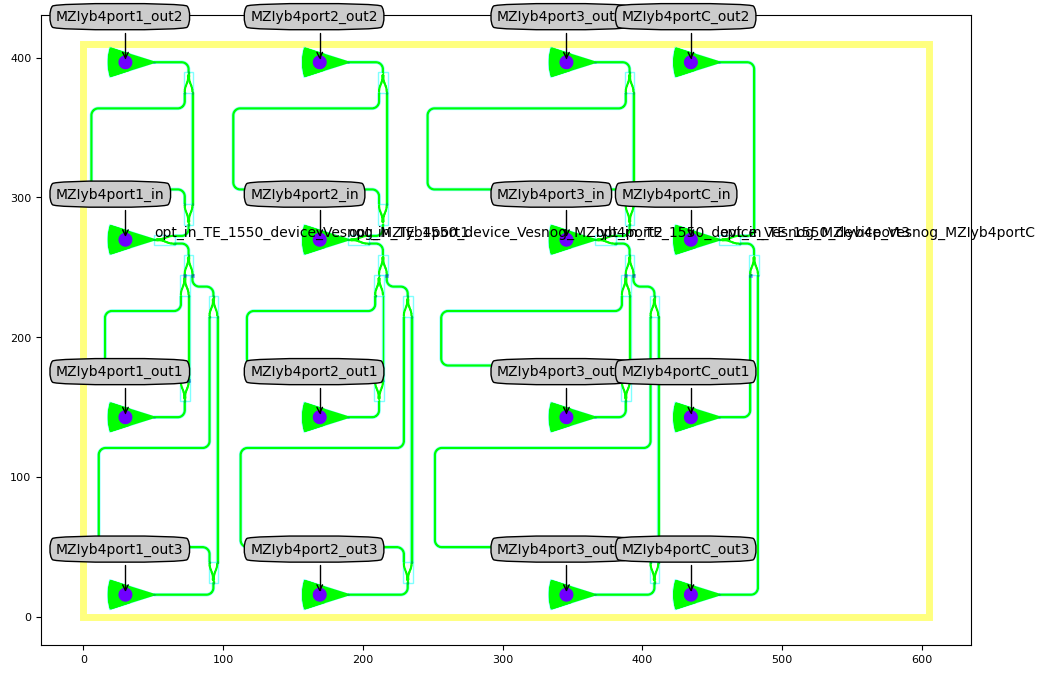

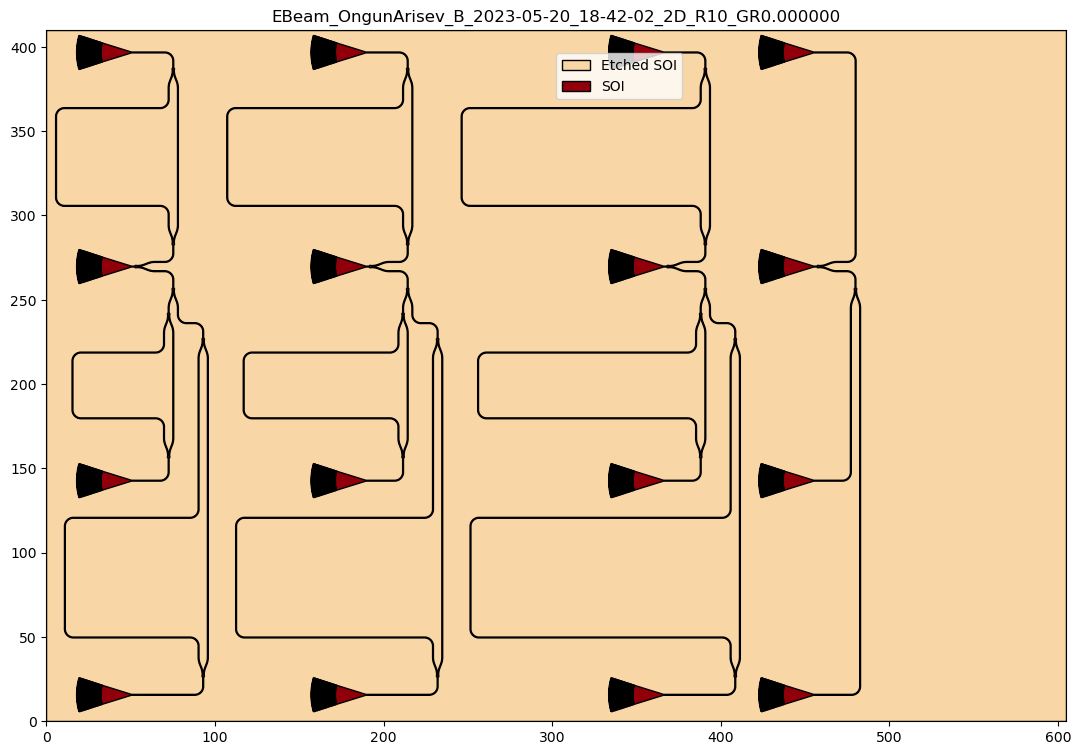

C:\Users\ongun\PycharmProjects\ipkiss_training\EBeam_Vesnog_B.gds

In [11]:
# Layout
filename = "EBeam_Vesnog_B.gds"
cell_lv = top_cell.Layout()
cell_lv.append(text_elems)
cell_lv.visualize(annotate=True)
cell_lv.visualize_2d()
cell_lv.write_gdsii(filename, layer_map=output_layer_map)

In [12]:
# Circuit model
cell_cm = top_cell.CircuitModel()
wavelengths = np.linspace(1.50, 1.58, 4001)
S_total = cell_cm.get_smatrix(wavelengths=wavelengths)

C:\ProgramData\Anaconda3\envs\ipkiss3\lib\site-packages\ipkiss3\simulation\engines\caphe_circuit_sim\caphenodegenerator.py:376: UserWarning: The following child nodes are not connected and will be removed:
floorplan
  warn(msg)


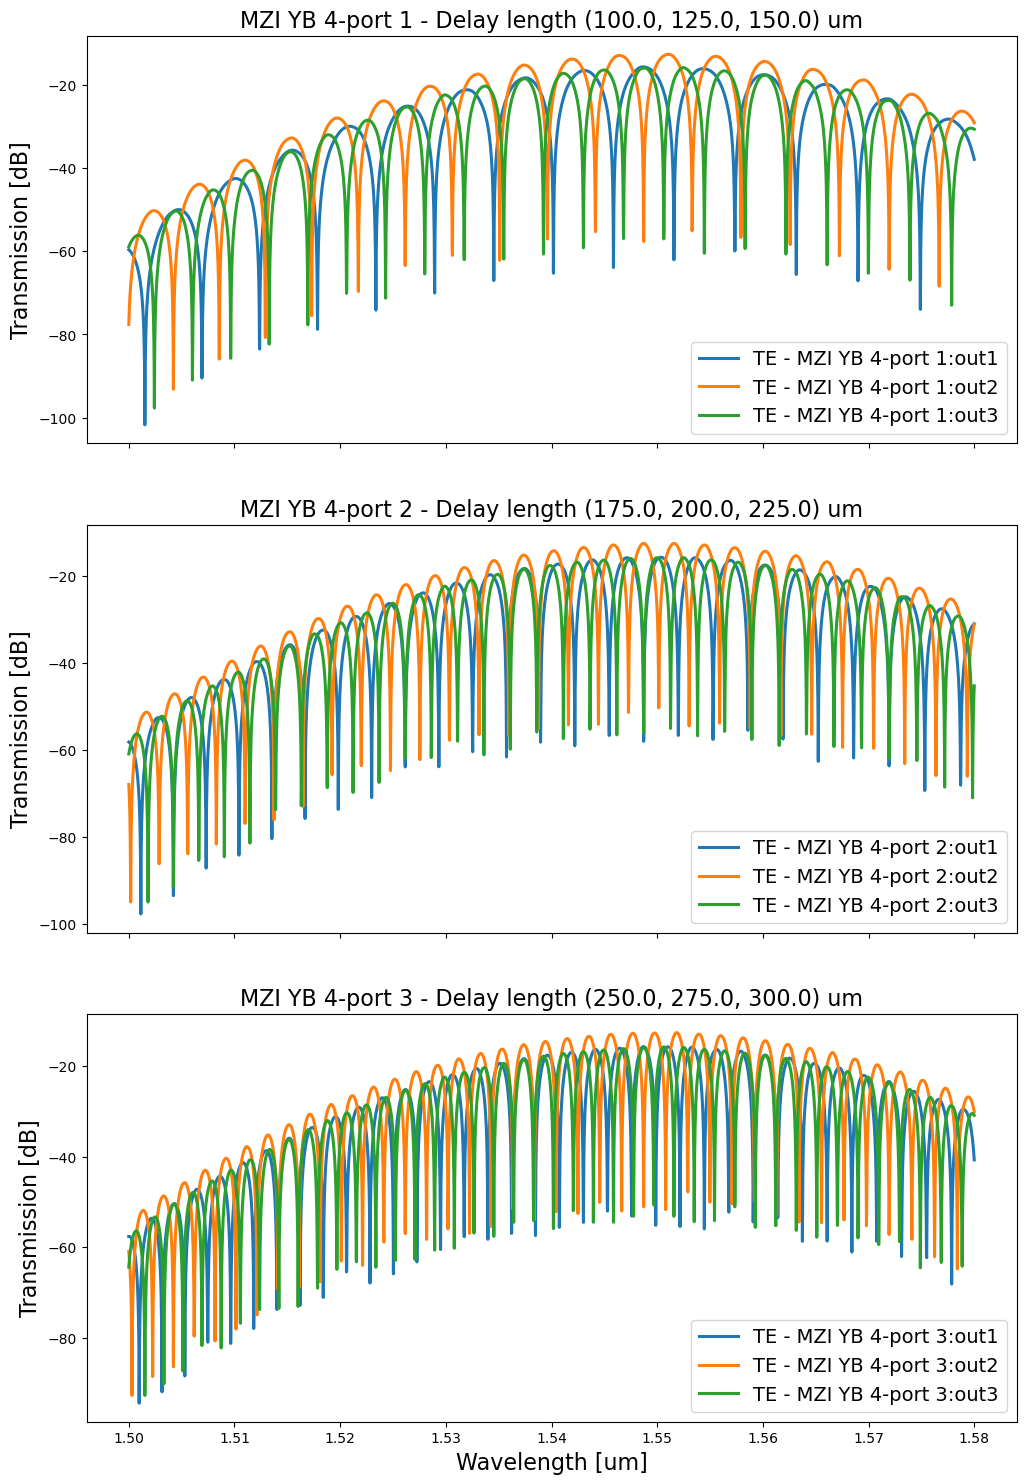

Done


In [13]:
# Plotting
fig, axs = plt.subplots(3, sharex="all", figsize=(12, 18))

# Dictionary for saving variables
m_dict = {}

for ind, delay_length in enumerate(delay_lengths_tuples, start=1):
    # After the colon the mode is selected (two modes) / for the particular examples S-matrix has 12x12x2 entries
    # not counting the ones due to wavelength
    tr_out1 = i3.signal_power_dB(S_total["MZIyb4port{}_out1:0".format(ind), "MZIyb4port{}_in:0".format(ind)])
    tr_out2 = i3.signal_power_dB(S_total["MZIyb4port{}_out2:0".format(ind), "MZIyb4port{}_in:0".format(ind)])
    tr_out3 = i3.signal_power_dB(S_total["MZIyb4port{}_out3:0".format(ind), "MZIyb4port{}_in:0".format(ind)])

    # Indices of the axes will be zero based
    ax_idx = ind - 1
    axs[ax_idx].plot(wavelengths, tr_out1, "-", linewidth=2.2, label="TE - MZI YB 4-port {}:out1".format(ind))
    axs[ax_idx].plot(wavelengths, tr_out2, "-", linewidth=2.2, label="TE - MZI YB 4-port {}:out2".format(ind))
    axs[ax_idx].plot(wavelengths, tr_out3, "-", linewidth=2.2, label="TE - MZI YB 4-port {}:out3".format(ind))

    axs[ax_idx].set_ylabel("Transmission [dB]", fontsize=16)
    axs[ax_idx].set_title("MZI YB 4-port {} - Delay length {} um".format(ind, delay_length), fontsize=16)
    axs[ax_idx].legend(fontsize=14, loc=4)
    m_dict[f"MZI_YB_4port_{delay_length}"] = {"out1": tr_out1, "out2": tr_out2, "out3": tr_out3}

savemat(f'./data/MZI_circuitB.mat', m_dict)
with open(f'./data/MZI_circuitB.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump(m_dict, f)
axs[-1].set_xlabel("Wavelength [um]", fontsize=16)
plt.show()

print("Done")